# Care Team Engagment Prediction - Data Analysis

This notebook includes the following steps:
<ul>
<li> Read data file </li>
<li> Analysis to define Y </li>
<li> Hot words analys </li>
<li> Examin variables distribution </li>
</ul>

### 1. Read data file (locally or from S3) 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [56]:
%matplotlib inline

In [58]:
# Read local data file
df1 = pd.read_csv('data15.csv')

In [59]:
df1.columns

Index(['days_to_first_et', 'days_to_coach', 'days_to_kit', 'acceptance_month',
       'indication', 'gender', 'user_age', 'bio_length', 'reasons_length',
       'imagine_free_length', 'reason_limited_time',
       'reason_family_obligations', 'reason_work_obligations', 'reason_other',
       'pain_severity', 'pain_vas', 'pain_description_length', 'weight', 'bmi',
       'gad', 'phq', 'is_sedentary', 'is_overweight', 'is_passive_coping',
       'is_catastrophizing', 'hours_to_complete_aq', 'conversations',
       'user_initiated_conv', 'hh_initiated_conv',
       'inbound_coach_messages_1_week', 'inbound_member_messages_1_week',
       'inbound_coach_messages_length_1_week',
       'inbound_coach_messages_4_weeks', 'conversation_density',
       'week_1_words', 'night_messages', 'morning_messages',
       'afternoon_messages', 'evening_message', 'count_text_msg_from_coach',
       'days_to_first_text_msg_from_user', 'days_to_first_text_msg_from_coach',
       'count_opr_msg_from_coach',

In [60]:
df1.shape

(73619, 49)

In [61]:
df1.columns

Index(['days_to_first_et', 'days_to_coach', 'days_to_kit', 'acceptance_month',
       'indication', 'gender', 'user_age', 'bio_length', 'reasons_length',
       'imagine_free_length', 'reason_limited_time',
       'reason_family_obligations', 'reason_work_obligations', 'reason_other',
       'pain_severity', 'pain_vas', 'pain_description_length', 'weight', 'bmi',
       'gad', 'phq', 'is_sedentary', 'is_overweight', 'is_passive_coping',
       'is_catastrophizing', 'hours_to_complete_aq', 'conversations',
       'user_initiated_conv', 'hh_initiated_conv',
       'inbound_coach_messages_1_week', 'inbound_member_messages_1_week',
       'inbound_coach_messages_length_1_week',
       'inbound_coach_messages_4_weeks', 'conversation_density',
       'week_1_words', 'night_messages', 'morning_messages',
       'afternoon_messages', 'evening_message', 'count_text_msg_from_coach',
       'days_to_first_text_msg_from_user', 'days_to_first_text_msg_from_coach',
       'count_opr_msg_from_coach',

### 2. Define Y

<function matplotlib.pyplot.show(*args, **kw)>

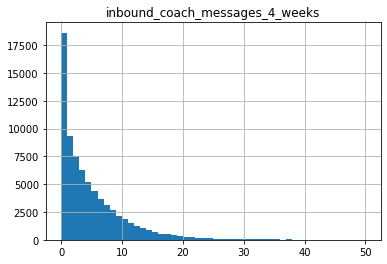

In [62]:
#df1['total_messages'] = df1['inbound_coach_messages_4_weeks'] + df1['inbound_member_messages_4_weeks']
t1 = pd.DataFrame(df1.loc[:,'inbound_coach_messages_4_weeks'])
t1.hist(range=(0,50), bins=50)
plt.show

In [63]:
# 25% of 53000 = 13,250
limit = 7

print('Our goal is to map out 25% of members, which is {0} user'.format (int(0.25* t1.shape[0])))
print('Setting inbound messages to coach (in first 4 week) limit to {0}'.format(limit))
mid_tier_count = t1[t1['inbound_coach_messages_4_weeks'] > 7].shape[0]
print('With current limit, we got {0} members'.format(mid_tier_count))

Our goal is to map out 25% of members, which is 18404 user
Setting inbound messages to coach (in first 4 week) limit to 7
With current limit, we got 15524 members


## Days to coach


<function matplotlib.pyplot.show(*args, **kw)>

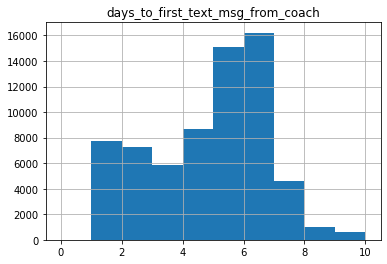

In [64]:
t2 = pd.DataFrame(df1.loc[:,'days_to_first_text_msg_from_coach'])
t2.hist(range=(0,10), bins=10)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

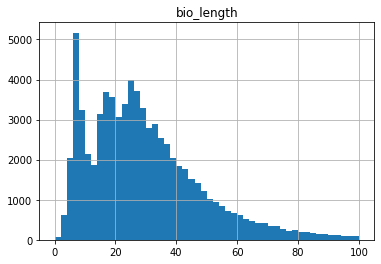

In [65]:
t2 = pd.DataFrame(df1.loc[:,'bio_length'])
t2.hist(range=(0,100), bins=50)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

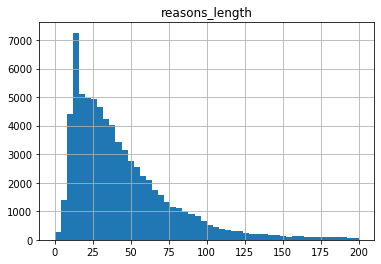

In [66]:
t2 = pd.DataFrame(df1.loc[:,'reasons_length'])
t2.hist(range=(0,200), bins=50)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

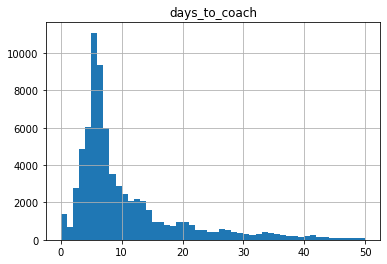

In [67]:
t2 = pd.DataFrame(df1.loc[:,'days_to_coach'])
t2.hist(range=(0,50), bins=50)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

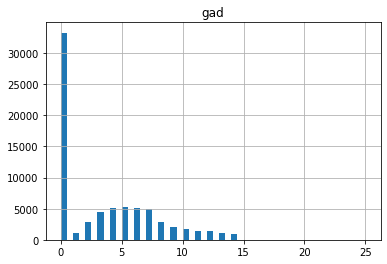

In [68]:

t2 = pd.DataFrame(df1.loc[:,'gad'])
t2.hist(range=(0,25), bins=50)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

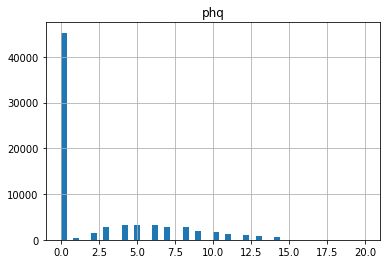

In [69]:

t2 = pd.DataFrame(df1.loc[:,'phq'])
t2.hist(range=(0,20), bins=50)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

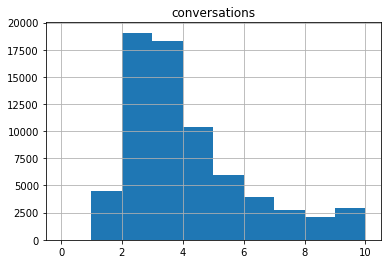

In [70]:


t2 = pd.DataFrame(df1.loc[:,'conversations'])
t2.hist(range=(0,10), bins=10)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

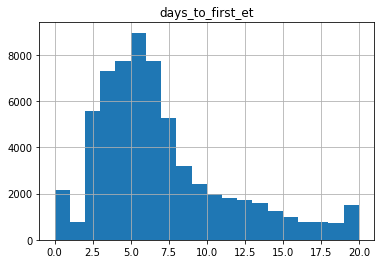

In [71]:

t2 = pd.DataFrame(df1.loc[:,'days_to_first_et'])
t2.hist(range=(0,20), bins=20)
plt.show



## Hot words Analysis

In [72]:
df1['hot_word']   =  df1['surgery_message'] + df1['call_message'] + df1['interaction_message'] + df1['video_message']
total_hot_words   = (df1['hot_word']            > 0).sum()
surgery_count     = (df1['surgery_message']     > 0).sum()
call_count        = (df1['call_message']        > 0).sum()
interaction_count = (df1['interaction_message'] > 0).sum()
video_count       = (df1['video_message']       > 0).sum()

print ('{0} members out of {1} actually used hot word, this is {2:2.2}%'.format(total_hot_words, df1.shape[0], total_hot_words*100/df1.shape[0]))
print ('Surgery used by {0} members'.format(surgery_count))
print ('Call used by {0} members'.format(call_count))
print ('Interaction {0} members'.format(interaction_count))
print ('Video {0} members'.format(video_count))


KeyError: 'surgery_message'

In [73]:
# Is there a correlation between hot words and number of messages?

hot_word_and_chatty = np.where((df1['Y'] == True) & (df1['hot_word'] > 0),1,0).sum()
hot_word_and_not_chatty = np.where((df1['Y'] == False) & (df1['hot_word'] > 0),1,0).sum()

print ('{0} members used hot words but sent overall less then 7 messages'.format(hot_word_and_not_chatty))
print ('{0} members used hot words but sent overall more then 7 messages'.format(hot_word_and_chatty))


KeyError: 'Y'

## Variables distibution

<function matplotlib.pyplot.show(*args, **kw)>

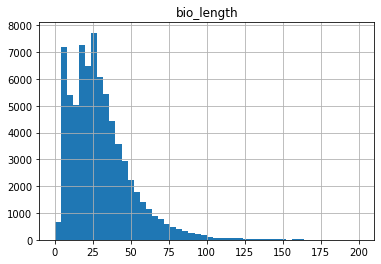

In [74]:
t2 = pd.DataFrame(df1.loc[:,'bio_length'])
t2.hist(range=(0,200), bins=50)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

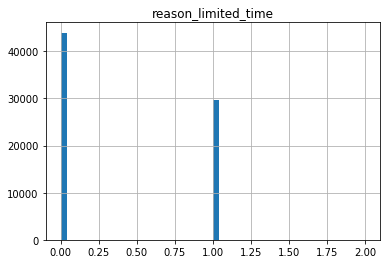

In [75]:

t2 = pd.DataFrame(df1.loc[:,'reason_limited_time'])
t2.hist(range=(0,2), bins=50)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

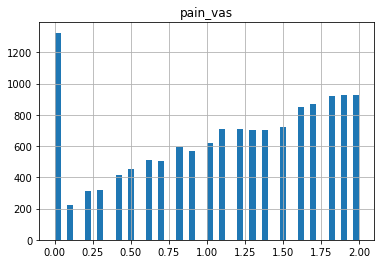

In [76]:

t2 = pd.DataFrame(df1.loc[:,'pain_vas'])
t2.hist(range=(0,2), bins=50)
plt.show

In [77]:


t2 = pd.DataFrame(df1.loc[:,'surgery_1yr'])
t2.hist(range=(0,2), bins=50)
plt.show

KeyError: 'surgery_1yr'

In [78]:
t3 = pd.DataFrame(df1.loc[:,'is_gender_female'])
t3.hist(range=(0,1), bins=50)
plt.show


KeyError: 'is_gender_female'

<function matplotlib.pyplot.show(*args, **kw)>

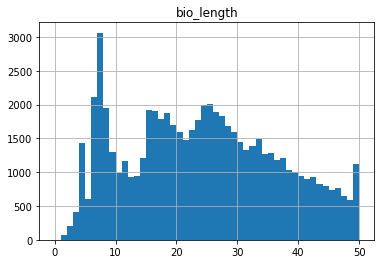

In [79]:
t2 = pd.DataFrame(df1.loc[:,'bio_length'])
t2.hist(range=(0,50), bins=50)
plt.show

In [80]:
df1 = pd.read_csv('analysisData1.csv')

In [81]:
df1[df1['days_to_coach'] < 0]

,days_to_first_et,days_to_coach,days_to_kit,acceptance_month,user_age,bio_length,reasons_length,imagine_free_length,reason_limited_time,reason_family_obligations,...,Retail,Transportation and Warehousing,Unkown,Utilities,Wholesale,bmi_underweight,bmi_healthy,bmi_overweight,bmi_obese,Y


In [82]:
df1[df1['days_to_kit'] < 0]




,days_to_first_et,days_to_coach,days_to_kit,acceptance_month,user_age,bio_length,reasons_length,imagine_free_length,reason_limited_time,reason_family_obligations,...,Retail,Transportation and Warehousing,Unkown,Utilities,Wholesale,bmi_underweight,bmi_healthy,bmi_overweight,bmi_obese,Y


In [84]:
df1['pain_vas'].max()

10.0